In [1]:
import os
import sys
import random
import ROOT
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.16/00


In [2]:
def simulation(distance, doubleplane, energy, erel, neutron, physics, overwrite, air):
    outfile = "test.simu.root"
    parfile = "test.para.root"

    if not overwrite and os.path.isfile(outfile):
        print(f"Output {outfile} exists and overwriting is disabled")
        return

    ROOT.ROOT.EnableThreadSafety()
    ROOT.FairLogger.GetLogger().SetLogVerbosityLevel("LOW")
    ROOT.FairLogger.GetLogger().SetLogScreenLevel("WARNING")

    vmcworkdir = os.environ["VMCWORKDIR"]
    os.environ["GEOMPATH"] = vmcworkdir + "/geometry"
    os.environ["CONFIG_DIR"] = vmcworkdir + "/gconfig"
    os.environ["PHYSICSLIST"] = f"QGSP_{physics.upper()}_HP"

    # Initialize Simulation
    run = ROOT.FairRunSim()
    run.SetName("TGeant4")
    run.SetStoreTraj(False)
    run.SetMaterials("media_r3b.geo")

    # Output
    run.SetSink(ROOT.FairRootFileSink(outfile))

    # Primary Generator
    generator = ROOT.FairPrimaryGenerator()
    psg = ROOT.R3BPhaseSpaceGenerator()
    psg.SetBeamEnergyDistribution_AMeV(ROOT.R3BDistribution1D.Delta(energy))
    psg.SetErelDistribution_keV(ROOT.R3BDistribution1D.Delta(erel))
    psg.AddHeavyIon(50, 132 - neutron)
    for n in range(neutron):
        psg.AddParticle(2112)
    generator.AddGenerator(psg)
    run.SetGenerator(generator)

    # Geometry
    cave = ROOT.R3BCave("Cave")
    cave.SetGeometryFileName("r3b_cave_vacuum.geo")
    run.AddModule(cave)

    if air:
        run.AddModule(ROOT.R3BNeutronWindowAndSomeAir(700, distance * 100))

    neuland_position = ROOT.TGeoTranslation(0.0, 0.0, distance * 100 + doubleplane * 10.0 / 2.0)
    neuland = ROOT.R3BNeuland(doubleplane, neuland_position)
    run.AddModule(neuland)

    magnetic_field = ROOT.R3BGladFieldMap("R3BGladMap")
    magnetic_field.SetScale(-0.6)
    run.SetField(magnetic_field)

    # Prepare to run
    run.Init()
    ROOT.TVirtualMC.GetMC().SetRandom(ROOT.TRandom3(random.randint(0, 10000)))
    ROOT.TVirtualMC.GetMC().SetMaxNStep(100000)

    # Runtime Database
    rtdb = run.GetRuntimeDb()
    parout = ROOT.FairParRootFileIo(True)
    parout.open(parfile)
    rtdb.setOutput(parout)
    rtdb.saveOutput()

    # Run
    run.Run(20000)
    del run

In [3]:
neutron = 4
physics = "inclxx"
air = True

In [ ]:
simulation(15, 30, 600, 500, neutron, physics, True, air)

4 True inclxx 2979 14.89 %
4 True inclxx 852 4.26 %


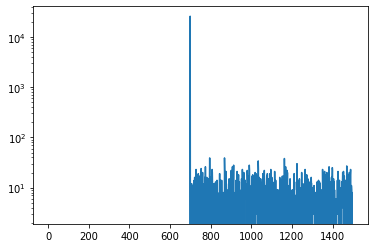

In [5]:
f = ROOT.TFile.Open("test.simu.root")

primary_neutron_track_ids = range(1, neutron + 1)

z_windowair = []
z_air = []
for e in f.evt:
    zs_wa = []
    zs_a = []
    
    for i, track in enumerate(e.MCTrack):
        z = track.GetStartZ()
        if z < 1500 and track.GetMotherId() in primary_neutron_track_ids:
            zs_wa.append(z)
            if z > 700:
                zs_a.append(z)
    
    if len(zs_wa) > 0:
        z_windowair.append(zs_wa)
    if len(zs_a) > 0:
        z_air.append(zs_a)

print(neutron, air, physics, len(z_windowair), round(len(z_windowair) / f.evt.GetEntries() * 100, 2), "%")
print(neutron, air, physics, len(z_air), round(len(z_air) / f.evt.GetEntries() * 100, 2), "%")

flatten = lambda l: [item for sublist in l for item in sublist]
histna = np.histogram(flatten(z_windowair), range=(0, 1500), bins=1500)
plt.plot(histna[1][:-1], histna[0])
plt.yscale("log")

In [6]:
os.remove("test.simu.root")
os.remove("test.para.root")

In [7]:
# 1n Window+Air inclxx 3.84%
# 1n Air        inclxx 1.11%
# 4n Window+Air inclxx 14.89%
# 4n Air        inclxx 4.26%